In [4]:
#question3 (a)
n='In-class network.txt'
import networkx as nx
import matplotlib.pyplot as plt
import sys

sys.path.append(r'D:\Chauying\Files\Python\GIT\networkie\networkie\gen')
sys.path.append(r'D:\Chauying\Files\Python\GIT\networkie\networkie\utils')
import Custom as Cs
import Measures as Mes

g=Cs.LoadFromFile(n).from_in_class_network()


In [2]:
#question3 (b)
nodes_total=len(list(g.nodes()))
edges_total=len(list(g.edges()))
degree_total=0
for i in list(g.nodes()):
    degree_total+=g.degree(i)
degree_mean=degree_total/nodes_total
total_length,number=0,0
for i in range(len(g.nodes())):
    l=list(range(len(list(g.nodes()))))[i+1:]
    for j in l:
        number+=1
        if nx.has_path(g,i,j):
            total_length+=(len(nx.shortest_path(g,source=i,target=j))-1)
mean_length=total_length/number
m=0
for i in list(nx.connected_components(g)):
    if len(i)>=m:
        m=len(i)

print('the number of nodes:',nodes_total)
print('the number of edges:',edges_total)
print('average degree:',degree_mean)
print('average path length:',mean_length)
print('the size of the largest connected component:',m)


the number of nodes: 75
the number of edges: 109
average degree: 2.9066666666666667
average path length: 1.7254054054054053
the size of the largest connected component: 45


In [3]:
#question3 (c)
e_max=75*74/2
print('e/e_max:',edges_total/e_max)


e/e_max: 0.03927927927927928


[1, 1, 5, 3, 6, 4, 5, 6, 2, 9, 2, 2, 5, 5, 1, 4, 1, 3, 5, 4, 4, 1, 1, 1, 6, 5, 0, 2, 1, 1, 2, 3, 1, 5, 1, 4, 1, 4, 5, 4, 1, 4, 1, 3, 2, 2, 2, 4, 3, 5, 1, 4, 1, 3, 1, 1, 4, 1, 2, 1, 1, 2, 2, 3, 4, 2, 4, 4, 3, 5, 8, 3, 2, 3, 0]


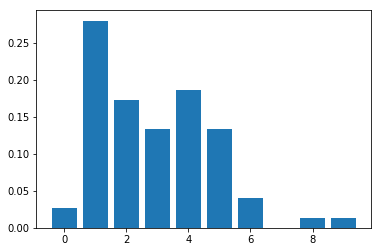

In [4]:
#question3 (d)

vector_k=Mes.Node(g).degree_dist()
print(vector_k)
degree_d=[]
count_d=[]
for i in list(g.nodes()):
    degree_d.append(g.degree(i))
degree_d=sorted(degree_d)
for i in list(set(degree_d)):
    count_d.append(degree_d.count(i)/len(degree_d))
plt.bar(list(set(degree_d)),count_d)
plt.show()
    
    

In [3]:
#question3 (e)
Mes.compute_num_triangles(g)
                    


52.0